In [2]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os
import matplotlib.pyplot as plt

image_dir = "data/naodevils/images"
data_dir = "data/naodevils/spqr_autolabel_and_manual_train_patchified.csv"
val_dir = "data/naodevils/spqr_manual_val_patchified.csv"


In [3]:

from math import isnan
class BallDataset(Dataset):
    def __init__(self, data_dir, images_dir, transform=None):
        self.data_dir = data_dir
        self.images_dir = images_dir
        self.transform = transform
        self.df = pd.read_csv(data_dir)

        self.dimension = transform.transforms[0].size[0]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.images_dir, row["image"])).convert("L")  # Convert to grayscale
        patch_dim = (row["patch_x"], row["patch_y"], row["patch_x"] + row["patch_size"], row["patch_y"] + row["patch_size"])
        patch = img.crop(patch_dim)
        resize_ratio = self.dimension / row["patch_size"]
        x = (row["center_x"] - row["patch_x"]) * resize_ratio if row["patch_contains_ball"] else float('nan')
        y = (row["center_y"] - row["patch_y"]) * resize_ratio if row["patch_contains_ball"] else float('nan')
        r = row["radius"] * resize_ratio if row["patch_contains_ball"] else float('nan')
        if self.transform:
            patch = self.transform(patch)
        patch = patch * 255.0


        assert isnan(x) or x < 32, (row["patch_x"], row["patch_size"], row["center_x"], x)

        return patch, row["patch_contains_ball"], {"x":x, "y":y, "r":r}

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

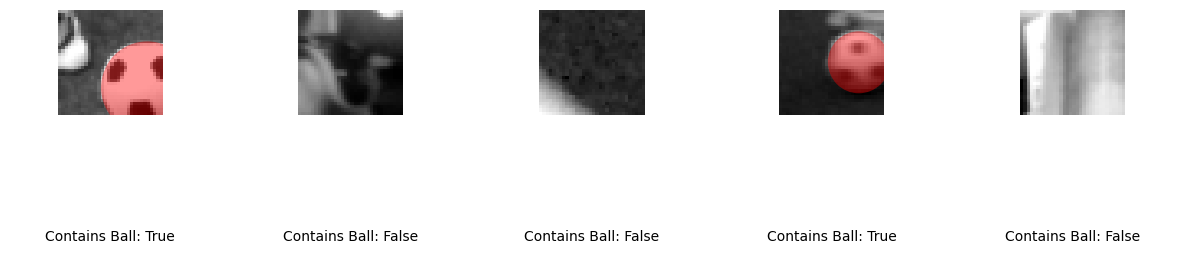

In [4]:
from matplotlib.patches import Circle

dataset = BallDataset(data_dir, image_dir, transform)
validation = BallDataset(val_dir, image_dir, transform)

batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation, batch_size=batch_size, shuffle=True)

sample = next(iter(data_loader))

num_images = 5

ig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 3))

for i in range(num_images):
    axes[0, i].imshow(sample[0][i][0], cmap='gray')
    if sample[1][i]:
        c = Circle((sample[2]["x"][i].item(),sample[2]["y"][i].item()), sample[2]["r"][i].item())
        c.set_facecolor((1.0,0.,0.,0.4))
        axes[0, i].add_patch(c)
    axes[0, i].axis('off')
    axes[1, i].text(0.5, 0, f'Contains Ball: {sample[1][i]}', horizontalalignment='center')  # Add text under each image
    axes[1, i].axis('off')  # Turn off axis for text

plt.show()

In [9]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_residual=False):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.use_residual = use_residual

    def forward(self, x):
        z = self.depthwise(x)
        z = self.pointwise(z)
        z = self.bn(z)
        z = self.relu(z) + x if self.use_residual else self.relu(z)
        return z


class BallPerceptor(nn.Module):
    def __init__(self, backbone_size = 9):
        super(BallPerceptor, self).__init__()
        
        self.conv1 = DepthwiseSeparableConv(1, 8, stride=1)
        self.conv2 = DepthwiseSeparableConv(8, 16, stride=1)
        self.conv3 = DepthwiseSeparableConv(16, 32, stride=1)
        
        backbone_layers = []
        for _ in range(backbone_size):
            backbone_layers.append(DepthwiseSeparableConv(32, 32, stride=1,use_residual=True))

        self.backbone = nn.Sequential(*backbone_layers)

        self.pool = nn.MaxPool2d(2, 2)
 
        self.classifier = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        self.segmenter = nn.Sequential(
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3), # x, y, r
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = self.backbone(x)

        feature_map = x.view(-1, 32 * 4 * 4)

        classification = self.classifier(feature_map) if self.training else torch.sigmoid(self.classifier(feature_map))
        segmentation = self.segmenter(feature_map)
        return classification, segmentation

In [10]:
from torch.nn.modules.loss import _Loss

class Circular_DIoU(_Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def intersectionArea(self, X1, Y1, R1, X2, Y2, R2):
        d = torch.sqrt(((X2 - X1) * (X2 - X1)) + ((Y2 - Y1) * (Y2 - Y1)))

        # Case 1: no overlap 
        mask_1 = d > R1 + R2

        # Case 2: One circle is fully within the other
        mask_2 = ( d <= (R1 - R2) ) & ( R1 >= R2 )
        mask_3 = ( d <= (R2 - R1) ) & ( R2 > R1 )

        # Case 3: Partial overlap
        mask_else = ~(mask_1 | mask_2 | mask_3)

        intersection_area = torch.zeros_like(d, dtype=torch.float32)

        intersection_area[mask_2] = torch.pi * R2[mask_2] * R2[mask_2]
        intersection_area[mask_3] = torch.pi * R1[mask_3] * R1[mask_3]

        alpha = torch.acos(((R1[mask_else] * R1[mask_else]) + (d[mask_else] * d[mask_else]) - (R2[mask_else] * R2[mask_else])) / (2 * R1[mask_else] * d[mask_else])) * 2
        beta = torch.acos(((R2[mask_else] * R2[mask_else]) + (d[mask_else] * d[mask_else]) - (R1[mask_else] * R1[mask_else])) / (2 * R2[mask_else] * d[mask_else])) * 2
        
        a1 = (0.5 * beta * R2[mask_else] * R2[mask_else] ) - (0.5 * R2[mask_else] * R2[mask_else] * torch.sin(beta))
        a2 = (0.5 * alpha * R1[mask_else] * R1[mask_else]) - (0.5 * R1[mask_else] * R1[mask_else] * torch.sin(alpha))

        intersection_area[mask_else] = a1 + a2

        return intersection_area

    def forward(self, input, target):
        a1 = torch.pi * torch.pow(input[:,2], 2)
        a2 = torch.pi * torch.pow(target[:,2], 2)

        a1inta2 = self.intersectionArea(input[:,0], input[:,1], input[:,2], target[:,0], target[:,1], target[:,2])

        a1una2 = a1 + a2 - a1inta2

        center_diff = input[:,:2] - target[:,:2]

        center_dist = torch.norm(center_diff, dim=-1)
        D = torch.pow(center_dist, 2)/torch.pow(center_dist + input[:,2] + target[:,2], 2)

        DIoU = 1 - a1inta2/a1una2 + D

        if self.reduction == 'mean':
            return DIoU.mean()
        elif self.reduction == 'sum':
            return DIoU.sum()
        else:
            return DIoU


In [15]:
model = BallPerceptor()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
p_weight = torch.tensor([0.5]).to(device)
classification_criterion = nn.BCEWithLogitsLoss(pos_weight=p_weight)
segmentation_criterion = Circular_DIoU()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 5
log_rate = 100
eval_rate = 300

r = torch.rand((1, 1, 32, 32))

print(model(r))

model.to(device)


(tensor([[-0.2084]], grad_fn=<AddmmBackward0>), tensor([[-0.5628,  0.3315,  0.2298]], grad_fn=<AddmmBackward0>))


BallPerceptor(
  (conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pointwise): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
    (pointwise): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): DepthwiseSeparableConv(
    (depthwise): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (pointwise): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (bac

In [16]:
import tqdm
best_loss = 1e10000
PATH = "strong.pt"

if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))
    model.to(device)

detection_weight = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(data_loader, 0), total=len(dataset)//batch_size):
        inputs, labels = data[0].to(device), data[1].float().to(device)
        segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)

        classification_mask = labels == 1.

        optimizer.zero_grad()
        classification, segmentation = model(inputs)
        loss = classification_criterion(classification, labels.unsqueeze(1))

        loss = detection_weight*segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask]) + loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % log_rate == 0: 
            print('[Epoch %d, Batch %5d] Training loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / log_rate))
            running_loss = 0.0
    
        if (i + 1) % eval_rate == 0:
            model.eval()
            correct = 0
            total = 0
            val_loss = 0
            with torch.no_grad():
                for data in validation_loader:
                    images, labels = data[0].to(device), data[1].float().to(device)
                    segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)
                    classification_mask = labels == 1.

                    classification, segmentation = model(images)

                    val_loss += classification_criterion(classification, labels.unsqueeze(1))                    
                    val_loss += detection_weight*segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask])

                    predicted = torch.round(classification)
                    total += labels.size(0)
                    correct += (predicted == labels.unsqueeze(1)).sum().item()
            model.train()
            accuracy = 100 * correct / total
            val_loss /= total/batch_size
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), PATH)
            print('%d iterations --- Accuracy: %f %% --- Loss: %f ' % ((epoch + 1) * (i + 1), accuracy, val_loss))

    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].float().to(device)
            segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)
            classification_mask = labels == 1.

            classification, segmentation = model(images)

            val_loss += classification_criterion(classification, labels.unsqueeze(1))
            val_loss += detection_weight*segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask])


            predicted = torch.round(classification)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()
    model.train()
    accuracy = 100 * correct / total
    val_loss /= total/batch_size
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), PATH)
    print('END EPOCH %d --- Accuracy: %f %% --- Loss: %f' % ((epoch + 1), accuracy, val_loss))


print('Finished Training')

  0%|          | 2/1631 [00:06<1:20:24,  2.96s/it]

END EPOCH 3 --- Accuracy: 86.178483 % --- Loss: 0.127076 CNN CLASSIC


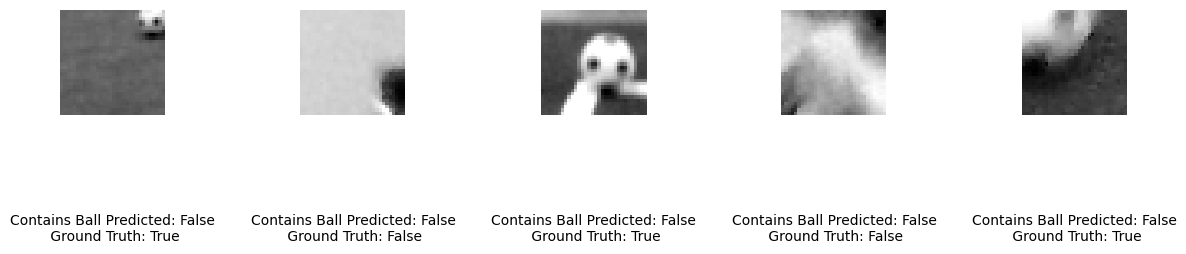

In [ ]:
PATH = "strong.pt"

model.load_state_dict(torch.load(PATH))
model.to(torch.device("cpu"))

num_images = 5
threshold = 0.8
sample = next(iter(validation_loader))

preds = model(sample[0])

detection, segmentation = preds

ig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 3))


for i in range(num_images):
    axes[0, i].imshow(sample[0][i][0], cmap='gray')
    if detection[i] > threshold:
        c = Circle((segmentation[i][0].item(),segmentation[i][1].item()), segmentation[i][2].item())
        c.set_facecolor((1.0,0.,0.,0.4))
        axes[0, i].add_patch(c)
    axes[0, i].axis('off')
    axes[1, i].text(0.5, 0, f'Contains Ball Predicted: {detection[i].item()> threshold}\n Ground Truth: {sample[1][i]}', horizontalalignment='center')  # Add text under each image
    axes[1, i].axis('off')  # Turn off axis for text

plt.show()


In [ ]:
import time
import onnx 
import onnxruntime as ort
import os
import tqdm
def measure_inference_time(model, input_size=(1, 1, 32, 32), device='cpu', num_runs=1000):
    input_tensor = torch.randn(input_size)
    model.to(device)
    
    torch.onnx.export(model, input_tensor, "tmp.onnx", export_params=True, opset_version=12)

    onnx_model = onnx.load("tmp.onnx")
    onnx.checker.check_model(onnx_model)

    onnx_input = {onnx_model.graph.input[0].name: input_tensor.detach().cpu().numpy()}
    
    onnx_session = ort.InferenceSession('tmp.onnx')

    total_time = 0
    for _ in tqdm.tqdm(range(num_runs)):
        start_time = time.time()
        onnx_session.run(None, onnx_input)
        total_time += time.time() - start_time

    avg_time = total_time / num_runs
    os.remove("tmp.onnx")
    return avg_time

measure_inference_time(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 107.12it/s]


0.008591138362884521

In [ ]:
!pip install onnxruntime

  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 10.0 MB/s eta 0:00:00
Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 19.5 MB/s eta 0:00:00
